## Heart Disease Prediction

### Importing the libraries

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler , LabelEncoder
from sklearn.impute import SimpleImputer , KNNImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split , cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score , confusion_matrix , classification_report , r2_score, mean_squared_error , mean_absolute_error

### Reading the dataset

In [73]:
df = pd.read_csv('heart_disease_uci.csv')
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### Getting the info about the data

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


### Checking for missing values

In [75]:
missing_values = df.isnull().sum()
print(missing_values)

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


### Visualization of missing values

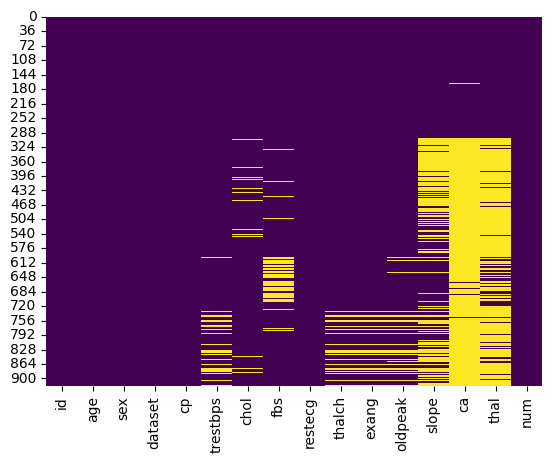

In [76]:
sns.heatmap(df.isnull(), cbar=False,cmap='viridis')
plt.show()

### Sorting the missing values in descending values

In [77]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

ca          611
thal        486
slope       309
fbs          90
oldpeak      62
trestbps     59
thalch       55
exang        55
chol         30
restecg       2
dtype: int64

### Listing all the missing values's index

In [78]:
missing_data_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()
missing_data_cols

['trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalch',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal']

### Splitting the columns based on their types

In [79]:
categorical_cols = ['thal', 'ca', 'slope', 'exang', 'restecg','fbs', 'cp', 'sex', 'num']
bool_cols = ['fbs', 'exang']
numeric_cols = ['oldpeak', 'thalch', 'chol', 'trestbps', 'age']

### Function for dealing with missing values

In [80]:
def impute_categorical_missing_data(passed_col):

    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]

    other_missing_cols = [col for col in missing_data_cols if col != passed_col]

    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)

    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    if len(df_null) > 0:
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])

    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):

    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]

    other_missing_cols = [col for col in missing_data_cols if col != passed_col]

    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    if len(df_null) > 0:
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])

    return df_combined[passed_col]

### Applying the function and impute the missing values

In [81]:
import warnings
warnings.filterwarnings('ignore')

for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%")
    if col in categorical_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in numeric_cols:
        df[col] = impute_continuous_missing_data(col)
    else:
        pass

Missing Values trestbps : 6.41%
MAE = 12.978554913294797 

RMSE = 16.867623654375997 

R2 = 0.11164694053263002 

Missing Values chol : 3.26%
MAE = 45.163651685393255 

RMSE = 64.32352347681142 

R2 = 0.672238229173985 

Missing Values fbs : 9.78%
The feature 'fbs' has been imputed with 80.72 accuracy

Missing Values restecg : 0.22%
The feature 'restecg' has been imputed with 64.13 accuracy

Missing Values thalch : 5.98%
MAE = 16.64595375722544 

RMSE = 21.798589085699273 

R2 = 0.3090508559799128 

Missing Values exang : 5.98%
The feature 'exang' has been imputed with 79.19 accuracy

Missing Values oldpeak : 6.74%
MAE = 0.5638255813953488 

RMSE = 0.7957744728425931 

R2 = 0.39669357153507256 

Missing Values slope : 33.59%
The feature 'slope' has been imputed with 65.85 accuracy

Missing Values ca : 66.41%
The feature 'ca' has been imputed with 67.74 accuracy

Missing Values thal : 52.83%
The feature 'thal' has been imputed with 71.26 accuracy



In [82]:
df.isnull().sum()

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [83]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


## Let's perform EDA

In [84]:

print('Summery of the data')
summary_stats = df.describe()
print(summary_stats)

Summery of the data
               id         age    trestbps        chol      thalch     oldpeak  \
count  920.000000  920.000000  920.000000  920.000000  920.000000  920.000000   
mean   460.500000   53.510870  132.511717  200.596435  136.840554    0.974782   
std    265.725422    9.424685   18.557250  109.383981   25.357068    1.123008   
min      1.000000   28.000000    0.000000    0.000000   60.000000   -2.600000   
25%    230.750000   47.000000  120.000000  177.750000  120.000000    0.000000   
50%    460.500000   54.000000  130.000000  224.000000  138.000000    0.800000   
75%    690.250000   60.000000  140.430000  268.000000  156.000000    1.900000   
max    920.000000   77.000000  200.000000  603.000000  202.000000    6.200000   

               ca         num  
count  920.000000  920.000000  
mean     0.513043    0.995652  
std      0.823911    1.142693  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    1.000000  
75%      1.000000    2.000

### Let's plot histogram for numerical values

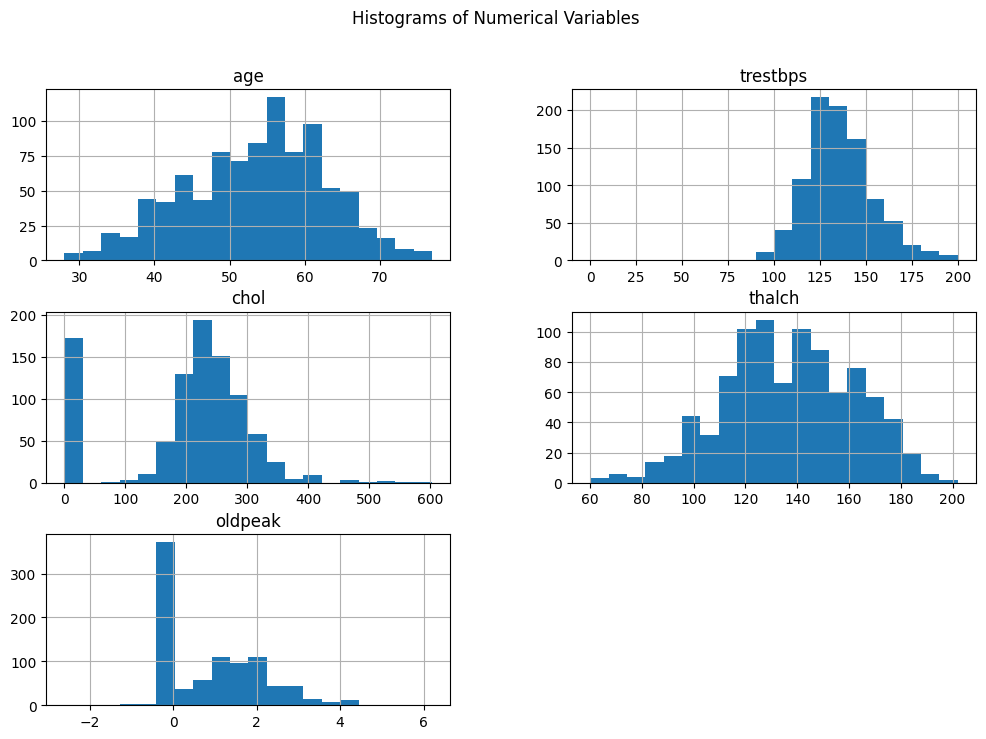

In [85]:
numerical_vars = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
df[numerical_vars].hist(bins=20, figsize=(12, 8))
plt.suptitle('Histograms of Numerical Variables')
plt.show()

### Histogram of the data that tell us the values counts of the data

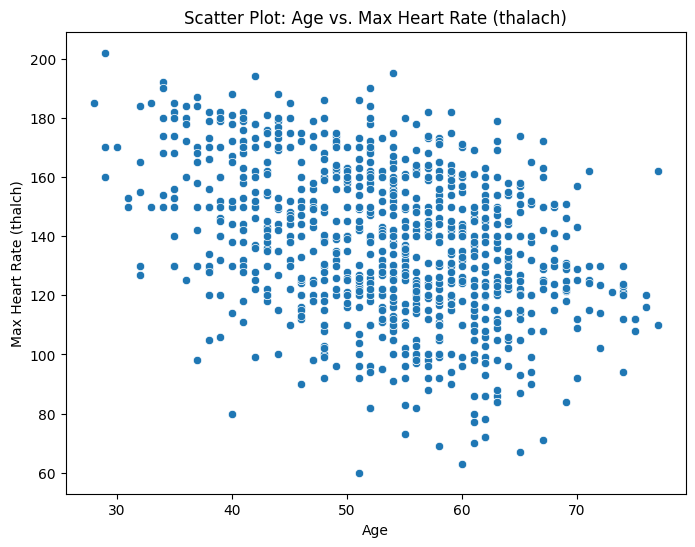

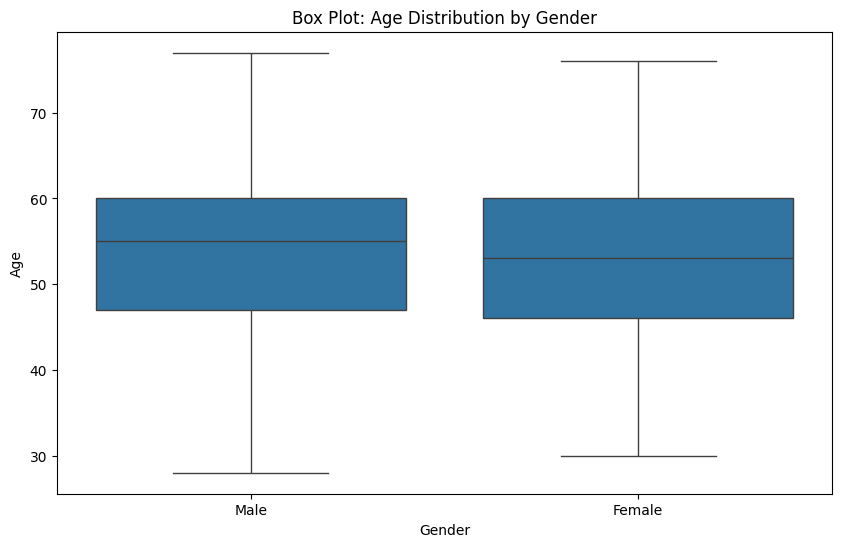

In [86]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='age', y='thalch', data=df)
plt.title('Scatter Plot: Age vs. Max Heart Rate (thalach)')
plt.xlabel('Age')
plt.ylabel('Max Heart Rate (thalch)')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='sex', y='age', data=df)
plt.title('Box Plot: Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

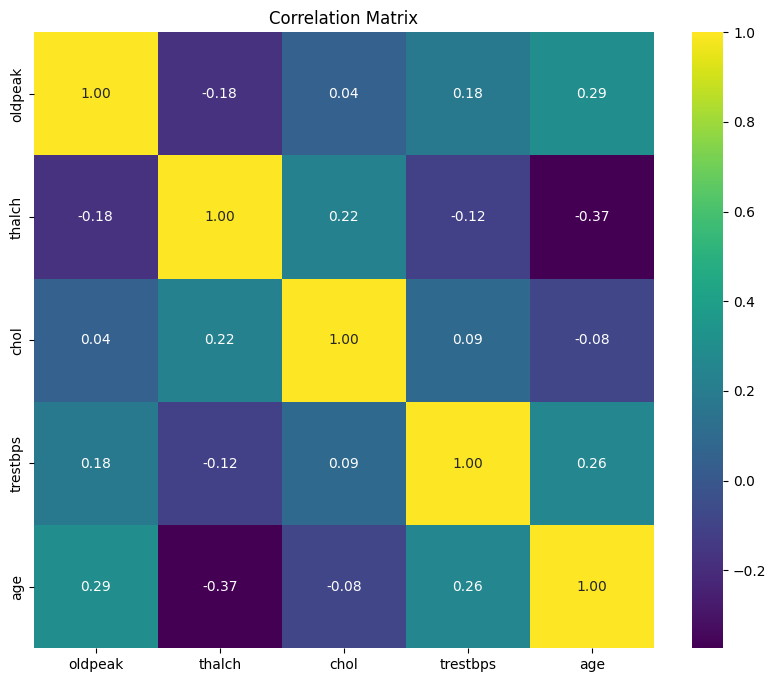

In [87]:
num_col= df[['oldpeak', 'thalch', 'chol', 'trestbps', 'age']]

corr_matrix = num_col.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Bar plot: Frequency distribution of categorical variables


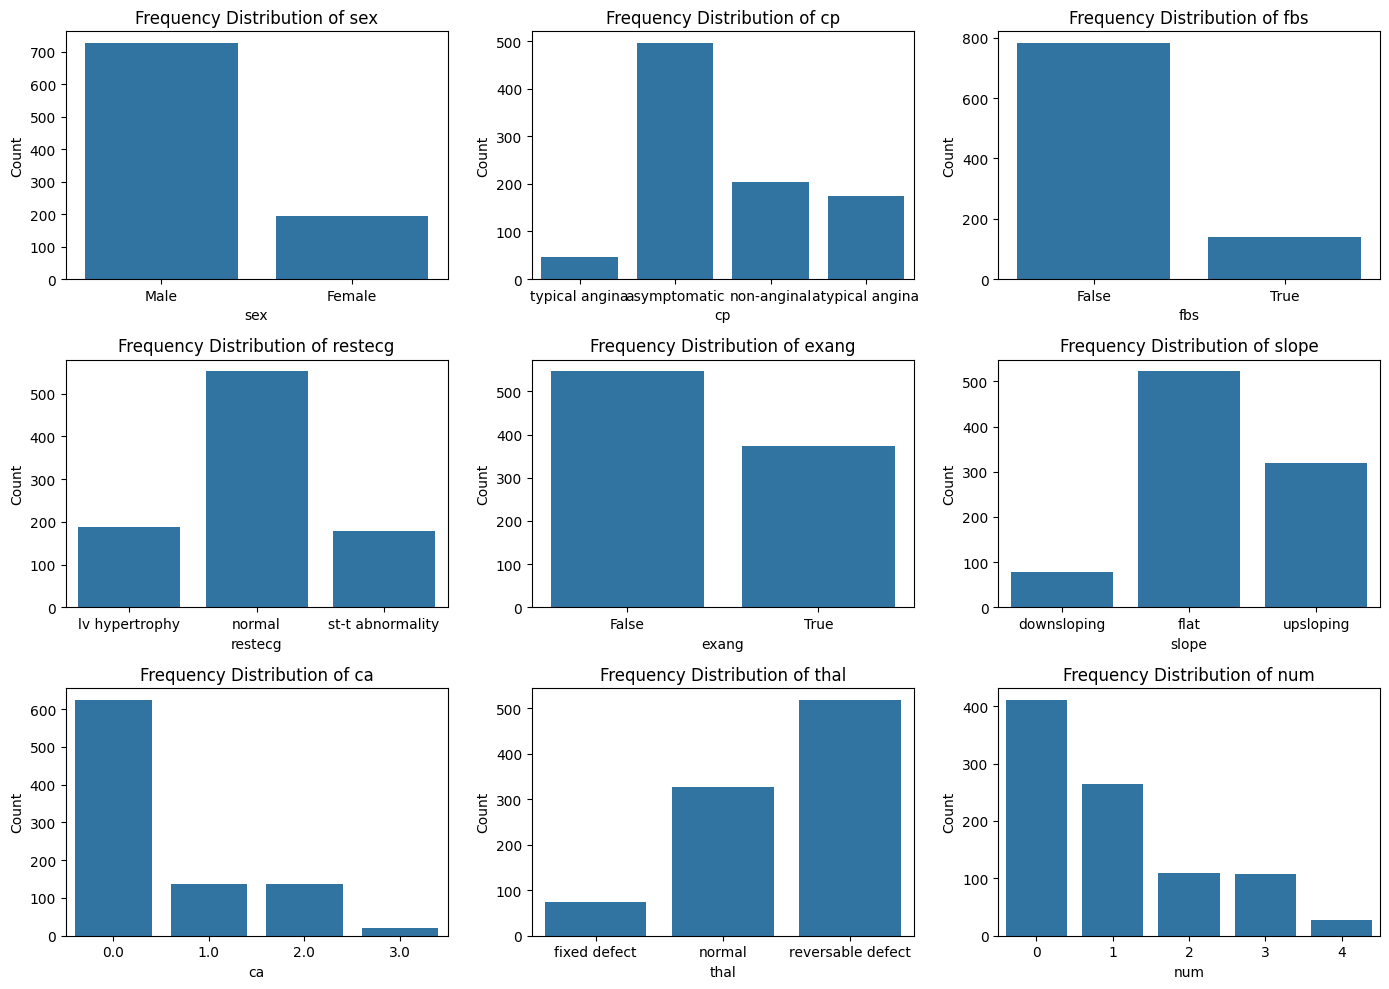

In [88]:
categorical_vars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'num']
plt.figure(figsize=(14, 10))
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=var, data=df)
    plt.title(f'Frequency Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Histoogram that tell ths value counts of categorical columns

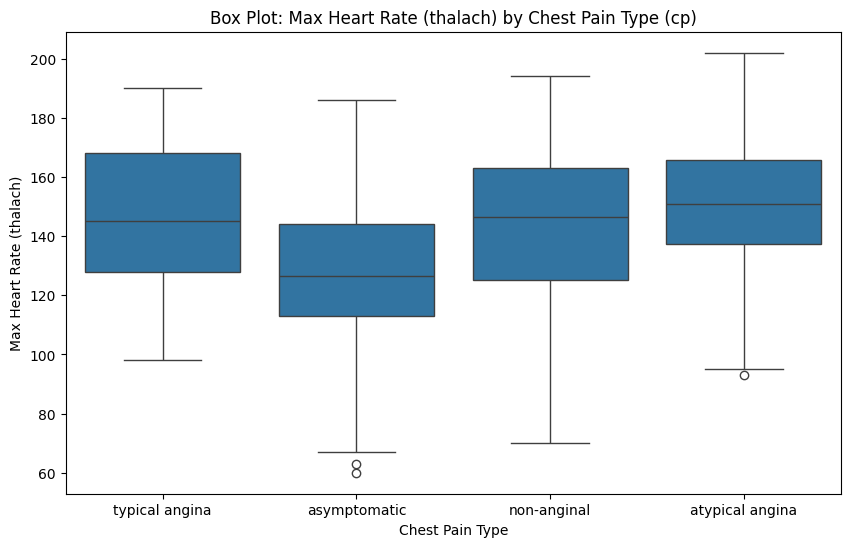

In [89]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='cp', y='thalch', data=df)
plt.title('Box Plot: Max Heart Rate (thalach) by Chest Pain Type (cp)')
plt.xlabel('Chest Pain Type')
plt.ylabel('Max Heart Rate (thalach)')
plt.show()

### Scatter plots :- cholesterol vs age based on heart disease presence

In [90]:
fig1 = px.scatter(df, x='age', y='chol', color='num', title='Scatter Plot: Age vs. Cholesterol colored by Heart Disease Presence',
                  labels={'age': 'Age', 'chol': 'Cholesterol', 'num': 'Heart Disease'})
fig1.update_layout(width=800, height=600)
fig1.show()

### Scatter plot: Resting Blood Pressure vs. Max Heart Rate colored by Heart Disease Presence

In [91]:
fig2 = px.scatter(df, x='trestbps', y='thalch', color='num', title='Scatter Plot: Resting Blood Pressure vs. Max Heart Rate colored by Heart Disease Presence',
                  labels={'trestbps': 'Resting Blood Pressure', 'thalch': 'Max Heart Rate', 'num': 'Heart Disease'})
fig2.update_layout(width=800, height=600)
fig2


In [92]:
fig = px.scatter_matrix(df, dimensions=['age', 'trestbps', 'chol', 'thalch', 'oldpeak'], color='num')
fig.show()

### Relationship of all Numeric columns based on NUM¶

In [93]:
Male   =  726
Female =  194
total = Male + Female

male_perc = (Male/total) * 100
female_perc = (Female/total) * 100

print(f'male percentage in the data : {male_perc: .2f}%')
print(f'female percentage in the data : {female_perc: .2f}%')

perc_diff = ((Male - Female) / Female )* 100

print(f'males are {perc_diff} more thean female')

male percentage in the data :  78.91%
female percentage in the data :  21.09%
males are 274.22680412371136 more thean female


### Groupby the dataset besed on age and their mean , median and mode

In [94]:
print(df.groupby('dataset')['age'].mean())
print(df.groupby('dataset')['age'].median())
print(df.groupby('dataset')['age'].agg(lambda x: pd.Series.mode(x)[0]))

dataset
Cleveland        54.351974
Hungary          47.894198
Switzerland      55.317073
VA Long Beach    59.350000
Name: age, dtype: float64
dataset
Cleveland        55.5
Hungary          49.0
Switzerland      56.0
VA Long Beach    60.0
Name: age, dtype: float64
dataset
Cleveland        58
Hungary          54
Switzerland      61
VA Long Beach    62
Name: age, dtype: int64


### Training the Machine Learning Model

#### Drop the unwanted columns

In [95]:
df.drop('id', axis=1 , inplace=True)
df.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### Standardize the numeric columns and Encode the categorical columns

In [96]:
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

from sklearn.preprocessing import LabelEncoder

categorical_cols = ['sex', 'dataset', 'cp' , 'restecg','fbs' , 'thal' , 'slope' ,'exang' ]

label_encoder = LabelEncoder()
df_pre=df.copy()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

print(df.head())

        age  sex  dataset  cp  trestbps      chol  fbs  restecg    thalch  \
0  0.714286    1        0   3     0.725  0.386401    1        0  0.633803   
1  0.795918    1        0   0     0.800  0.474295    0        0  0.338028   
2  0.795918    1        0   0     0.600  0.379768    0        0  0.485915   
3  0.183673    1        0   2     0.650  0.414594    0        1  0.894366   
4  0.265306    0        0   1     0.650  0.338308    0        0  0.788732   

   exang   oldpeak  slope        ca  thal  num  
0      0  0.556818      0  0.000000     0    0  
1      1  0.465909      1  1.000000     1    2  
2      1  0.590909      1  0.666667     2    1  
3      0  0.693182      0  0.000000     1    0  
4      0  0.454545      2  0.000000     1    0  


### Dealing with outliers

In [97]:
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR)))

df= df[~outliers.any(axis=1)]

print(df.head())

        age  sex  dataset  cp  trestbps      chol  fbs  restecg    thalch  \
0  0.714286    1        0   3     0.725  0.386401    1        0  0.633803   
2  0.795918    1        0   0     0.600  0.379768    0        0  0.485915   
3  0.183673    1        0   2     0.650  0.414594    0        1  0.894366   
4  0.265306    0        0   1     0.650  0.338308    0        0  0.788732   
5  0.571429    1        0   1     0.600  0.391376    0        1  0.830986   

   exang   oldpeak  slope        ca  thal  num  
0      0  0.556818      0  0.000000     0    0  
2      1  0.590909      1  0.666667     2    1  
3      0  0.693182      0  0.000000     1    0  
4      0  0.454545      2  0.000000     1    0  
5      0  0.386364      2  0.000000     1    0  


### Boxplot after removing outliers

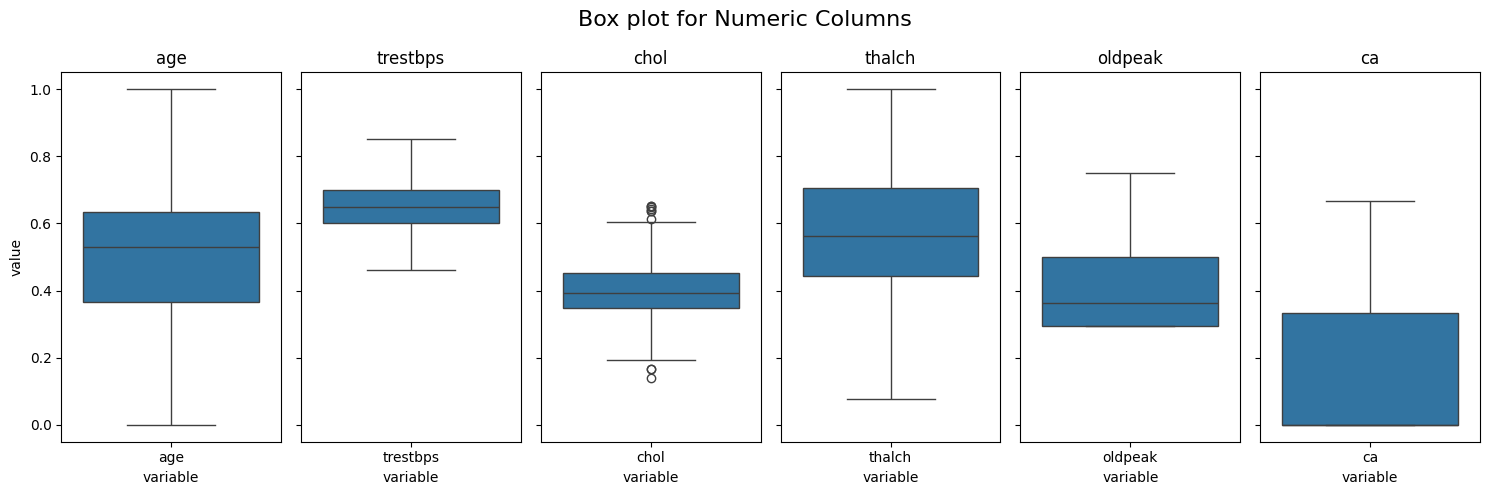

In [98]:
melted_df = pd.melt(df , value_vars=numeric_cols)
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(15, 5), sharey=True)

for i, col in enumerate(numeric_cols):
    sns.boxplot(x='variable', y='value', data=melted_df[melted_df['variable'] == col], ax=axes[i])
    axes[i].set_title(col)

fig.suptitle('Box plot for Numeric Columns', fontsize=16)

plt.tight_layout()
plt.show()

### Splitting the dataset into X and y

In [99]:
X = df.drop('num', axis=1)
y = df['num']

### Splitting the dataset into train and test dataset

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Applying different models and checking for accuracy

In [71]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier  , AdaBoostClassifier

models = {
    'Random Forest' : RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Ada Boost': AdaBoostClassifier(random_state=42),
    'XG Boost': XGBClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}


model_scores = []
for name , model in models.items():
    model.fit(X_train , y_train)


    y_pred = model.predict(X_test)
    metric = accuracy_score(y_test , y_pred)
    model_scores.append((name , metric))


sm = sorted(model_scores , key=lambda x :x[1] ,reverse = False)
for model in sm:
    print('accuracy score of' , f'{model[0]} is {model[1]}')

accuracy score of Naive Bayes is 0.408
accuracy score of Ada Boost is 0.52
accuracy score of Decision Tree is 0.568
accuracy score of XG Boost is 0.6
accuracy score of Random Forest is 0.608
accuracy score of Support Vector Machine is 0.64
accuracy score of K-Nearest Neighbors is 0.64
accuracy score of Gradient Boosting is 0.664
accuracy score of Logistic Regression is 0.664
